Dataset shape: (5000, 25)

First few rows:
   ID  default  LIMIT_BAL  AGE  SEX  EDUCATION  MARRIAGE  PAY_0  PAY_2  PAY_3  \
0   1      1.0   120000.0   43    1          2         2      2      2      2   
1   2      0.0   134000.0   39    2          1         1      0     -2      2   
2   3      0.0   384000.0   42    2          1         2      1      0     -1   
3   4      0.0   419000.0   54    2          1         1     -1     -1      2   
4   5      0.0    10000.0   43    2          1         2     -1      0      0   

   ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0  ...          0          0          0          0         0         0   
1  ...     116260     136868     105715      87264         0         0   
2  ...          0          0          0          0         0         0   
3  ...      43814      47880      62712      57436         0         0   
4  ...       6560          0       2237      28183         0         0   

   PAY_AMT3  PAY_AMT4  PA

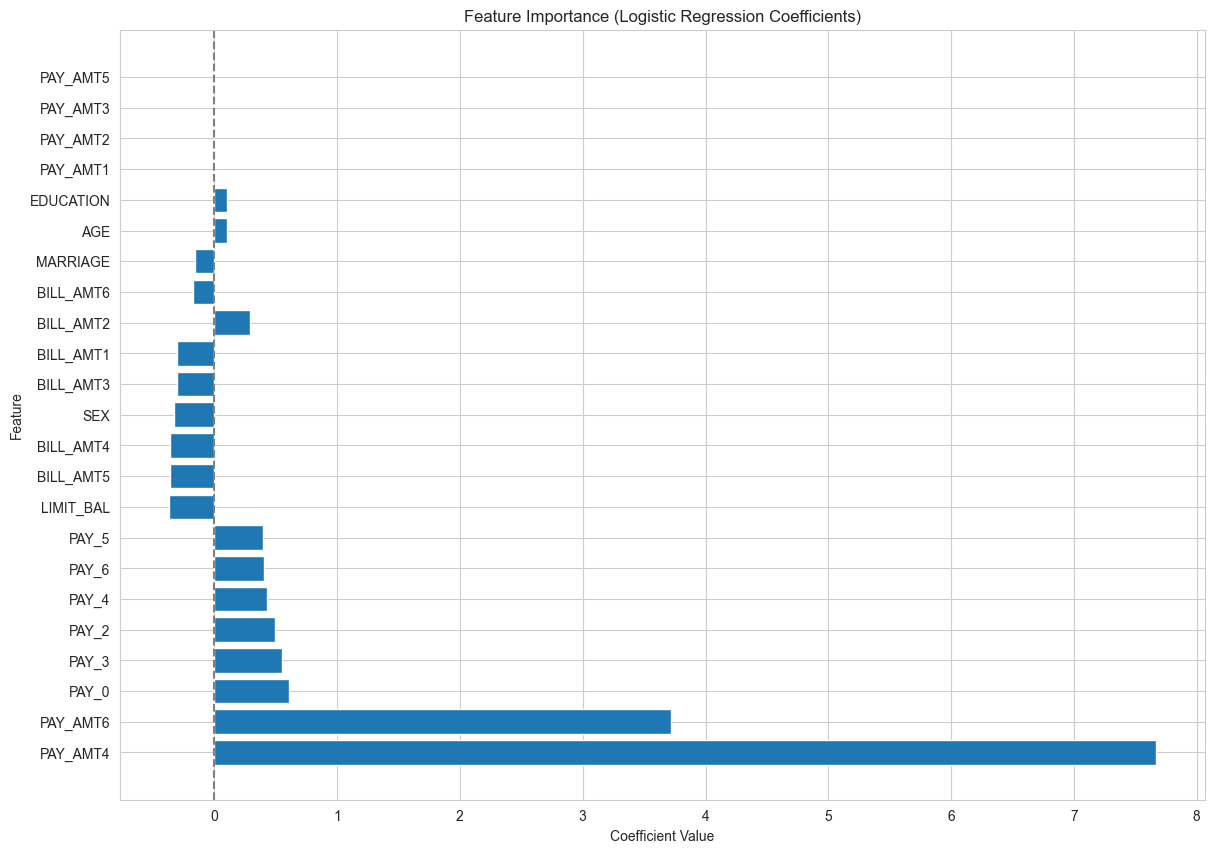


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      1170
         1.0       0.92      0.82      0.87       330

    accuracy                           0.95      1500
   macro avg       0.94      0.90      0.92      1500
weighted avg       0.95      0.95      0.94      1500



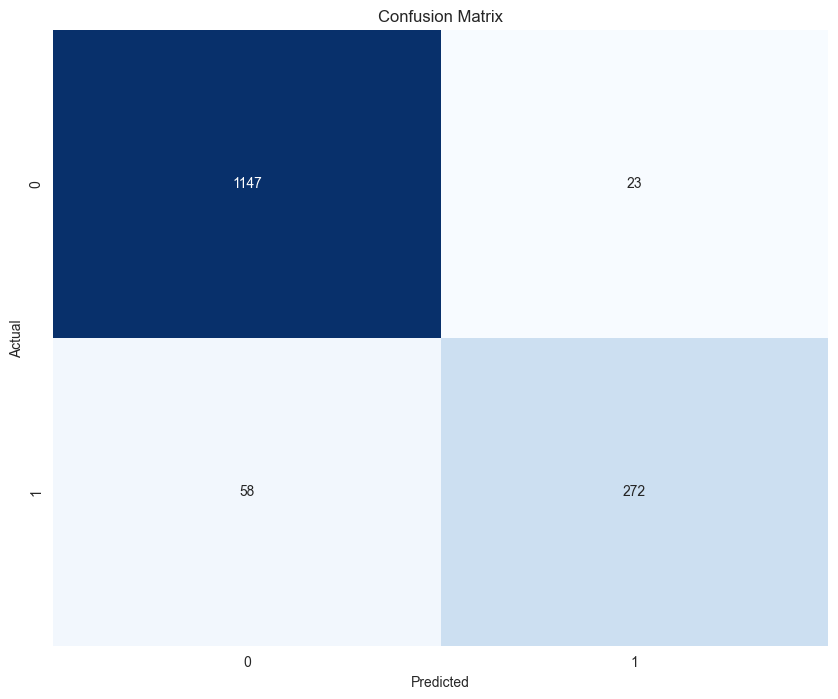

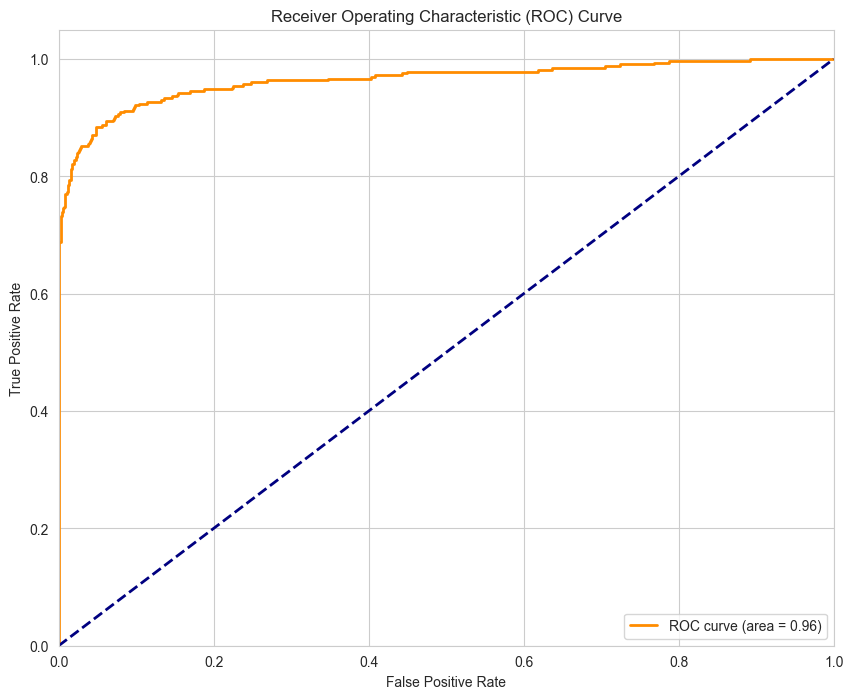

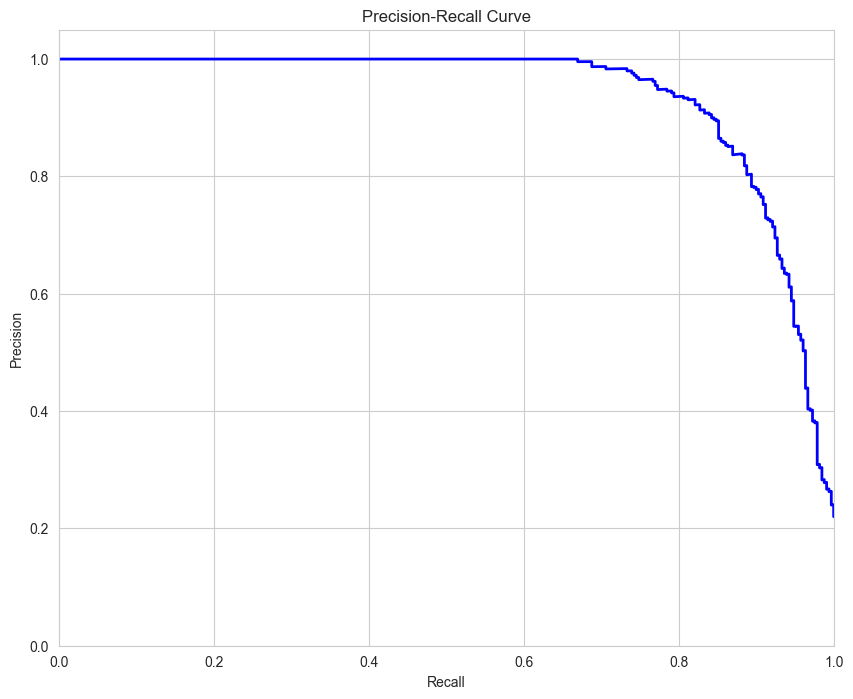

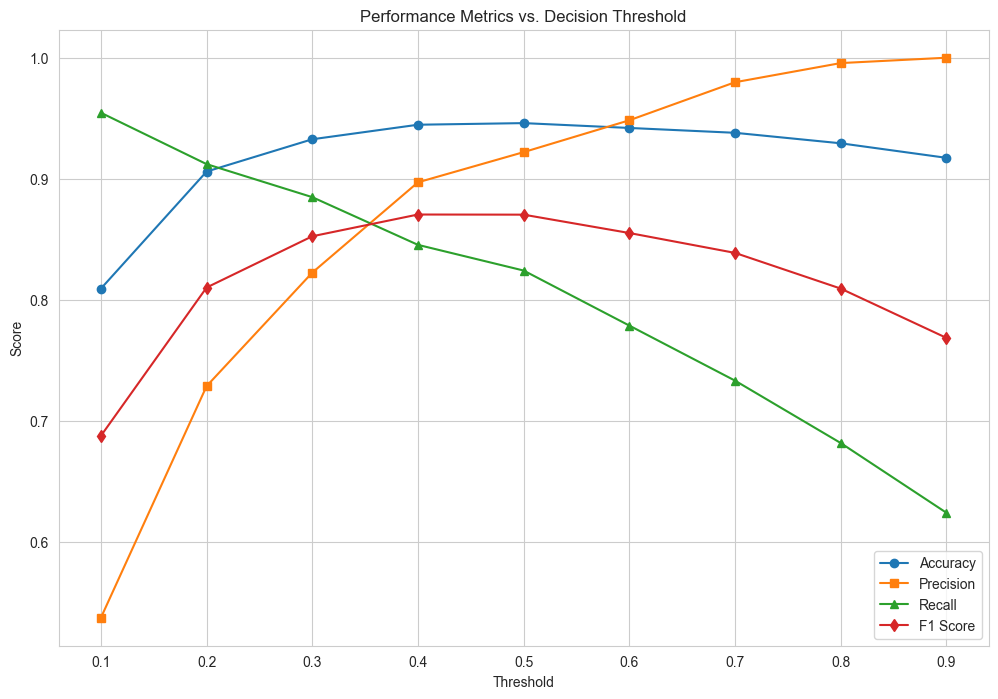

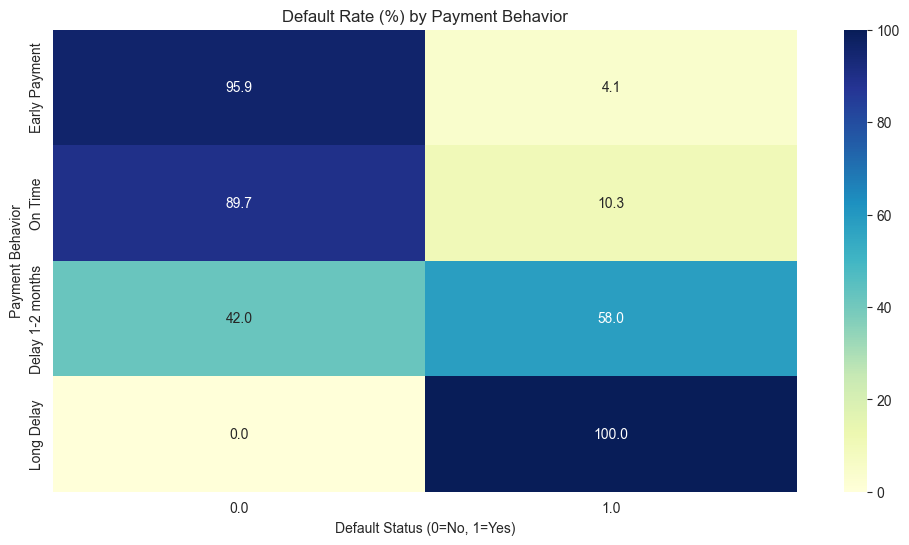


Model training and evaluation complete!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Load the synthetic data
df = pd.read_csv('./data/synthetic_credit_data.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Separate features and target
X = df.drop(['ID', 'default'], axis=1)
y = df['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate feature importance
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.axvline(x=0, color='gray', linestyle='--')
plt.savefig('./img/feature_importance_lr.png')
plt.show()

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('./img/confusion_matrix.png')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('./img/roc_curve.png')
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig('./img/precision_recall_curve.png')
plt.show()

# Plot the decision threshold analysis
thresholds = np.arange(0.1, 1, 0.1)
accuracy = []
precision = []
recall = []
f1 = []

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred_threshold))
    precision.append(precision_score(y_test, y_pred_threshold))
    recall.append(recall_score(y_test, y_pred_threshold))
    f1.append(f1_score(y_test, y_pred_threshold))

plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
plt.plot(thresholds, precision, label='Precision', marker='s')
plt.plot(thresholds, recall, label='Recall', marker='^')
plt.plot(thresholds, f1, label='F1 Score', marker='d')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.savefig('./img/threshold_analysis.png')
plt.show()

# Analyze model performance by payment behavior
# Create a new feature representing average payment delay
df['avg_payment_delay'] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)

# Let's categorize the delay
bins = [-10, -1, 0, 2, 8]
labels = ['Early Payment', 'On Time', 'Delay 1-2 months', 'Long Delay']
df['payment_behavior'] = pd.cut(df['avg_payment_delay'], bins=bins, labels=labels)

# Create a heatmap of default rates by payment behavior
payment_default = pd.crosstab(df['payment_behavior'], df['default'])
payment_default_pct = payment_default.div(payment_default.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(payment_default_pct, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Default Rate (%) by Payment Behavior')
plt.ylabel('Payment Behavior')
plt.xlabel('Default Status (0=No, 1=Yes)')
plt.savefig('./img/default_by_payment.png')
plt.show()

print("\nModel training and evaluation complete!")